In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# !unzip -uq "/content/ResizeDataset.zip" -d "/content"

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [4]:
train_dir='/content/drive/MyDrive/SkinDetect/EPISCAN/Test'

In [5]:
Labels = ['Tinea Ringworm', 'impetigo','intertrigo','scabbies']

In [6]:
print ("class : ")
for i in range(len(Labels)):
    print (i, end = " ")
    print (Labels[i])

class : 
0 Tinea Ringworm
1 impetigo
2 intertrigo
3 scabbies


In [7]:
print('Number of classes:',len(Labels))

Number of classes: 4


In [8]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16

In [9]:
IMAGE_SIZE

(224, 224)

In [22]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 154 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [11]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE]  )


In [23]:
do_fine_tuning = False
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True

else:
  feature_extractor.trainable = False

In [24]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 2915908 (11.12 MB)
Trainable params: 657924 (2.51 MB)
Non-trainable params: 2257984 (

In [14]:
LEARNING_RATE = 0.001
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [15]:
EPOCHS = 15

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)



Epoch 1/15
11/11 [==============================] - 28s 1s/step - loss: 1.5459 - accuracy: 0.7622 - val_loss: 0.3492 - val_accuracy: 0.9688
Epoch 2/15
11/11 [==============================] - 4s 369ms/step - loss: 0.8177 - accuracy: 0.7744 - val_loss: 0.3069 - val_accuracy: 0.9375
Epoch 3/15
11/11 [==============================] - 4s 353ms/step - loss: 0.5990 - accuracy: 0.7927 - val_loss: 0.3741 - val_accuracy: 0.9062
Epoch 4/15
11/11 [==============================] - 5s 453ms/step - loss: 0.4994 - accuracy: 0.8011 - val_loss: 0.2669 - val_accuracy: 0.9531
Epoch 5/15
11/11 [==============================] - 4s 354ms/step - loss: 0.4254 - accuracy: 0.8476 - val_loss: 0.3088 - val_accuracy: 0.9062
Epoch 6/15
11/11 [==============================] - 4s 363ms/step - loss: 0.3931 - accuracy: 0.8720 - val_loss: 0.2827 - val_accuracy: 0.9219
Epoch 7/15
11/11 [==============================] - 4s 397ms/step - loss: 0.2680 - accuracy: 0.9085 - val_loss: 0.3955 - val_accuracy: 0.8750
Epoch 8/

1/1 [==============================] - 0s 493ms/step
class: Tinea Ringworm, confidence: 0.478535


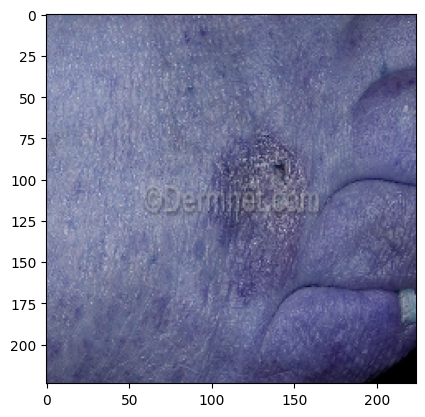

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 38ms/step
class: Tinea Ringworm, confidence: 0.496919


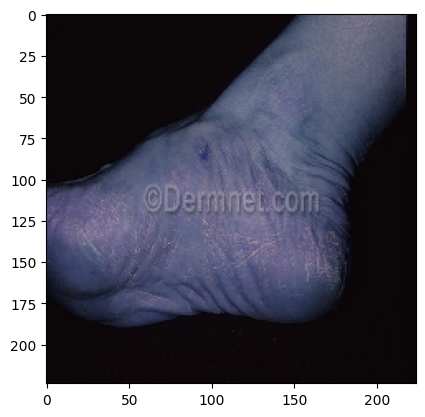

1/1 [==============================] - 0s 108ms/step
class: Tinea Ringworm, confidence: 0.671332


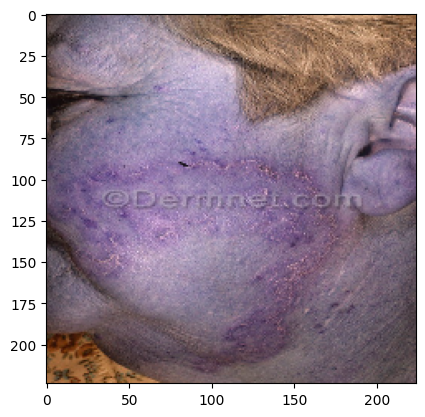

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 38ms/step
class: Scabbies, confidence: 0.716395


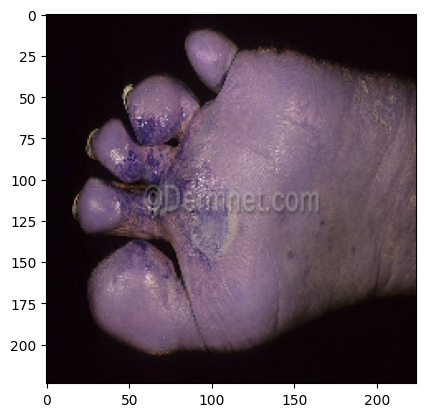

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 40ms/step
class: Scabbies, confidence: 0.491348


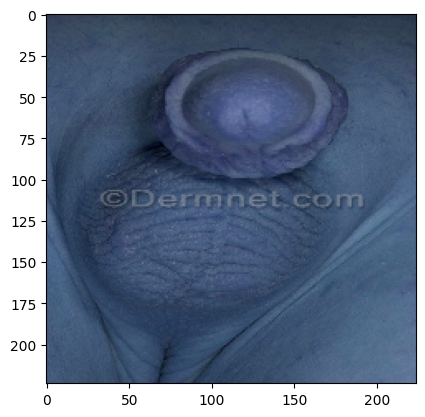

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 41ms/step
class: Tinea Ringworm, confidence: 0.482945


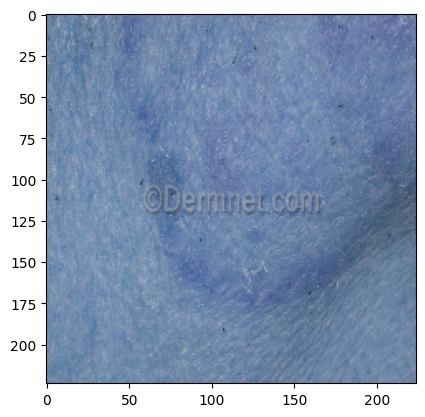

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 43ms/step
class: Scabbies, confidence: 0.691797


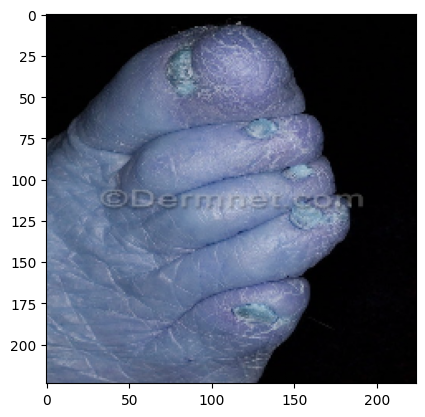

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 34ms/step
class: Intertrigo, confidence: 0.467565


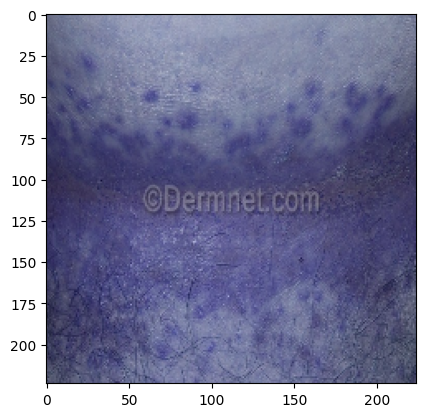

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 48ms/step
class: Scabbies, confidence: 0.580429


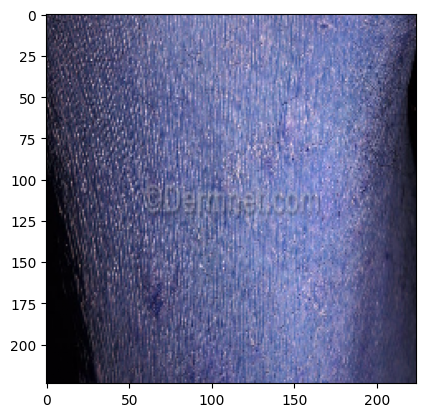

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 39ms/step
class: Scabbies, confidence: 0.539749


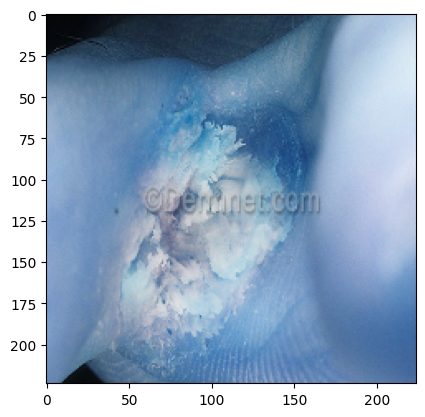

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 38ms/step
class: Scabbies, confidence: 0.773356


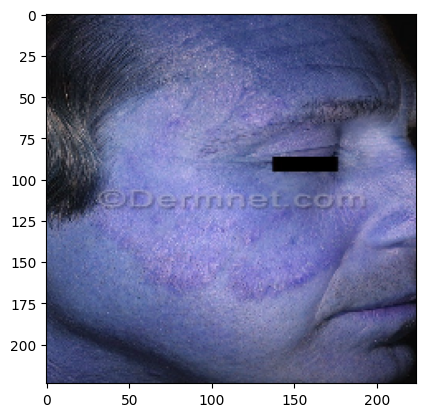

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 40ms/step
class: Intertrigo, confidence: 0.366125


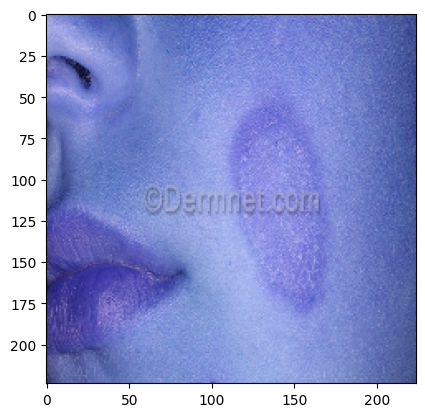

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 51ms/step
class: Scabbies, confidence: 0.533576


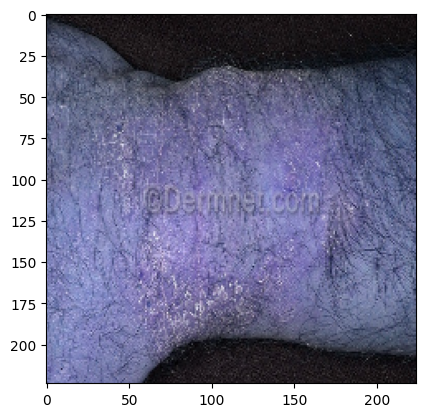

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 38ms/step
class: Scabbies, confidence: 0.804611


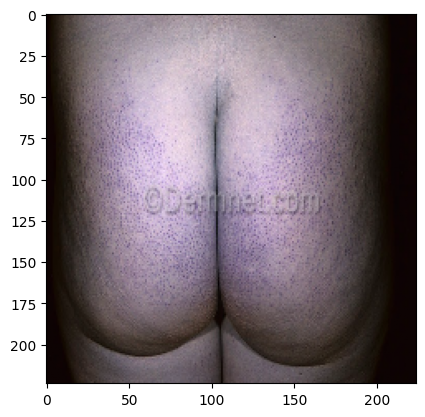

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 40ms/step
class: Tinea Ringworm, confidence: 0.640976


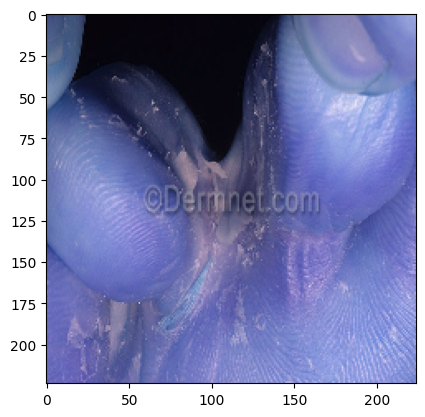

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 33ms/step
class: Scabbies, confidence: 0.607963


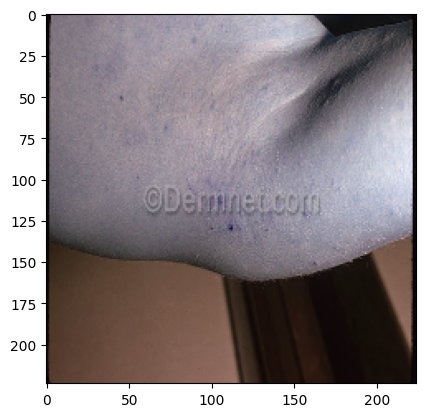

<Figure size 640x480 with 0 Axes>

In [25]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255

    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)

    return {Labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):


    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

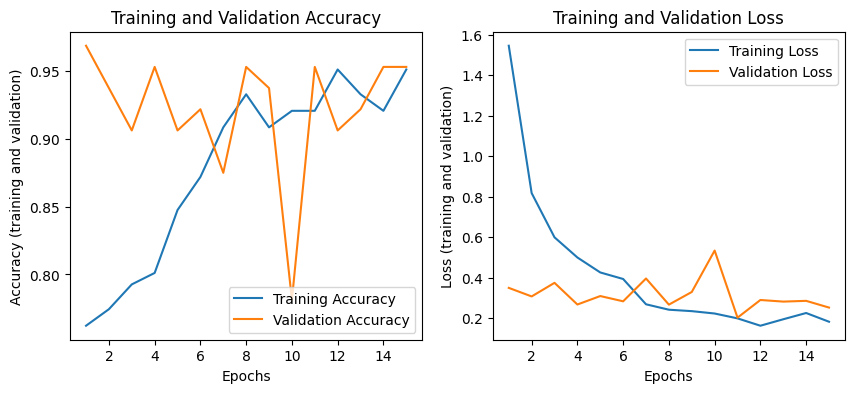

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already trained the model and obtained the history object
# history = model.fit(...)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)  # Adjusted epochs_range

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Epochs")
plt.show()


In [28]:
from sklearn.metrics import classification_report

# Assuming you have already defined your model architecture and loaded weights

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Generate predictions
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y_pred = np.argmax(predictions1, axis=1)

# Get true labels
y_true = validation_generator.classes

# Print classification report
print('Classification Report')
cr = classification_report(y_true=y_true, y_pred=y_pred, target_names=None)
print(cr)

# Evaluate the model
evaluates = model.evaluate(validation_generator)
print("Evaluation Results:", evaluates)


7/7 [==============================] - 4s 218ms/step
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.05      0.09        83
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.09      0.89      0.16         9

    accuracy                           0.12       100
   macro avg       0.27      0.23      0.06       100
weighted avg       0.84      0.12      0.09       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 [==============================] - 4s 347ms/step - loss: 1.8099 - accuracy: 0.1400
Evaluation Results: [1.8099026679992676, 0.14000000059604645]


Confusion Matrix


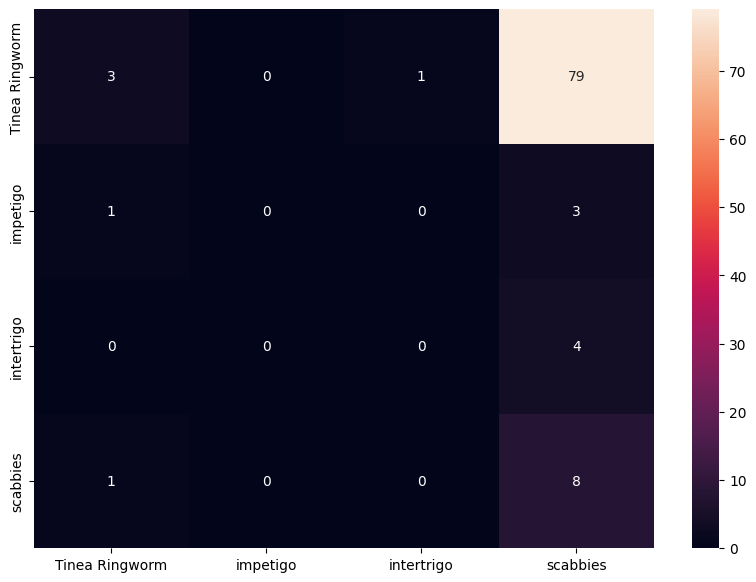

In [29]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)

# Get the class labels from class_indices and sort them based on class indices
class_labels = [class_label for class_label, index in sorted(validation_generator.class_indices.items(), key=lambda x: x[1])]

# Ensure that class_labels contain only the labels of the classes you have (4 in your case)
class_labels = class_labels[:4]

# Create the DataFrame with class labels as columns
df = pd.DataFrame(cm, columns=class_labels, index=class_labels)

plt.figure(figsize=(10, 7))
sn.heatmap(df, annot=True)
plt.show()

In [30]:
cd /content/drive/MyDrive/SkinDetect

/content/drive/MyDrive/SkinDetect


#Export as saved model and convert to TFLite

In [31]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)

export_path

'/tmp/saved_models/1699603865'

In [32]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [33]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)

    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: Tinea Ringworm, file: Tinea Ringworm/tinea-face-31.jpg
1/1 [==============================] - 1s 762ms/step
PREDICTED: class: Tinea Ringworm, confidence: 0.587802


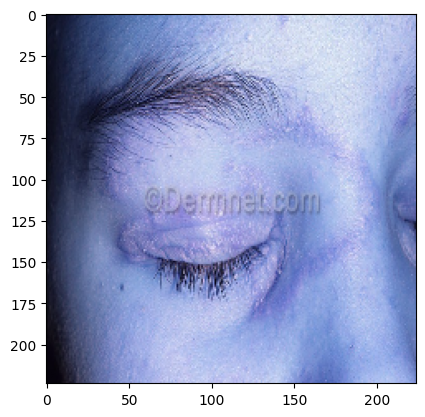

<Figure size 640x480 with 0 Axes>

SOURCE: class: Tinea Ringworm, file: Tinea Ringworm/tinea-foot-webs-48.jpg
1/1 [==============================] - 0s 42ms/step
PREDICTED: class: Scabbies, confidence: 0.497214


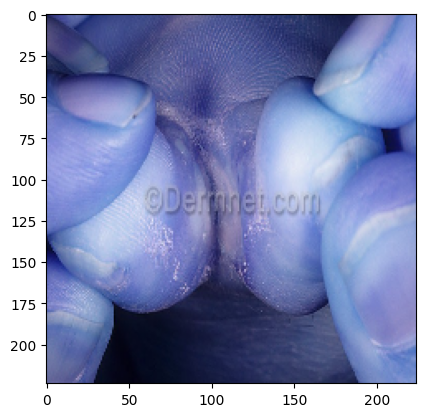

In [34]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()

In [36]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/data.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

mkdir: cannot create directory ‘tflite_models’: File exists


11545324